# 1. 데이터 로드 및 EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 데이터 파일 경로
ratings_path = './data/ml-100k/u.data'
movies_path = './data/ml-100k/u.item'

In [3]:
# MovieLens 100k의 ratings 데이터 (컬럼: user_id, item_id, rating, timestamp)
ratings_df = pd.read_csv(ratings_path, sep='\t',
                         names=['user_id', 'item_id', 'rating', 'timestamp'])

In [5]:
# movies 데이터 (영화 제목, 개봉일, 장르 등 포함)
movies_columns = ['item_id', 'title', 'release_data', 'vide_release_date', 'IMDb_URL',
                  'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                  'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                  'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies_df = pd.read_csv(movies_path, sep='|', names=movies_columns, encoding='latin-1')

In [8]:
# ratings와 movies 데이터 병합
merged_df = pd.merge(ratings_df, movies_df, on='item_id')

In [9]:
# 영화별 평균 평점과 평점 수 집계
movie_stats = merged_df.groupby('title')['rating'].agg(['mean', 'count']).reset_index()
movie_stats = movie_stats.sort_values(by='count', ascending=False)
print("상위 인기 영화:")
print(movie_stats.head())

상위 인기 영화:
                          title      mean  count
1398           Star Wars (1977)  4.358491    583
333              Contact (1997)  3.803536    509
498                Fargo (1996)  4.155512    508
1234  Return of the Jedi (1983)  4.007890    507
860            Liar Liar (1997)  3.156701    485


# 2. 장르별 평점 분석

In [10]:
# 영화 장르 컬럼 리스트
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                  'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                  'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

In [11]:
# 장르 데이터를 긴 형식(long format)으로 변환하여 각 영화가 속한 장르별 평점 확인
genre_ratings = merged_df.melt(id_vars=['user_id', 'item_id', 'rating', 'timestamp', 'title'],
                               value_vars=genre_columns, var_name='genre', value_name='is_genre')
# 해당 영화가 해당 장르에 속할 때만 필터링 (값이 1인 경우)
genre_ratings = genre_ratings[genre_ratings['is_genre'] == 1]

In [13]:
# 각 장르별 평균 평점 계산
genre_stats = genre_ratings.groupby('genre')['rating'].mean().reset_index()
print('\n장르별 평균 평점:')
print(genre_stats)


장르별 평균 평점:
          genre    rating
0        Action  3.480245
1     Adventure  3.503527
2     Animation  3.576699
3      Children  3.353244
4        Comedy  3.394073
5         Crime  3.632278
6   Documentary  3.672823
7         Drama  3.687379
8       Fantasy  3.215237
9     Film-Noir  3.921523
10       Horror  3.290389
11      Musical  3.521397
12      Mystery  3.638132
13      Romance  3.621705
14       Sci-Fi  3.560723
15     Thriller  3.509007
16          War  3.815812
17      Western  3.613269
18      unknown  3.200000


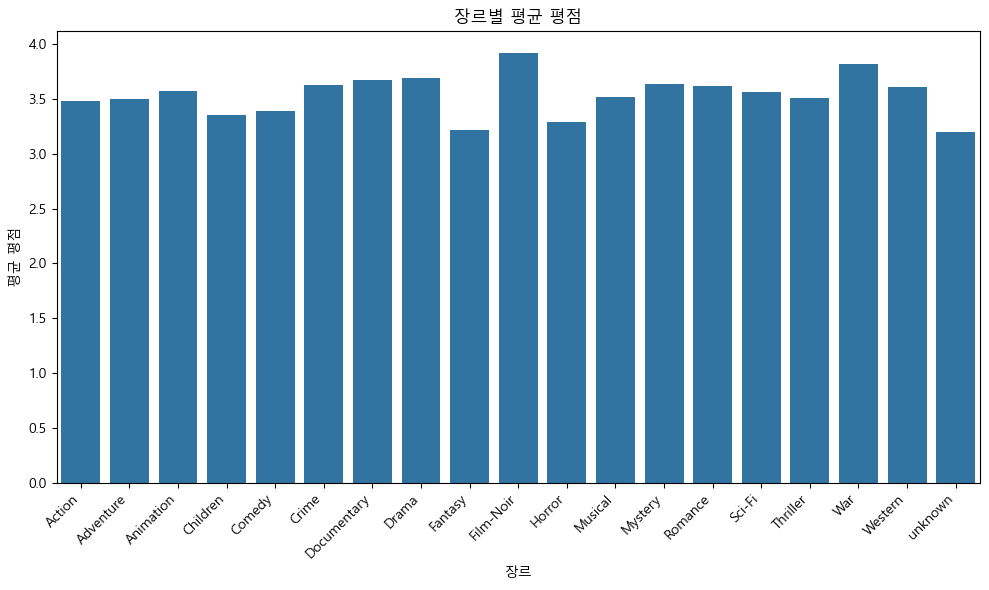

In [15]:
# 장르 평균 평점 시각화
import matplotlib
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10, 6))
sns.barplot(x='genre', y='rating', data=genre_stats)
plt.xticks(rotation=45, ha='right')
plt.title('장르별 평균 평점')
plt.xlabel('장르')
plt.ylabel('평균 평점')
plt.tight_layout()
plt.show()

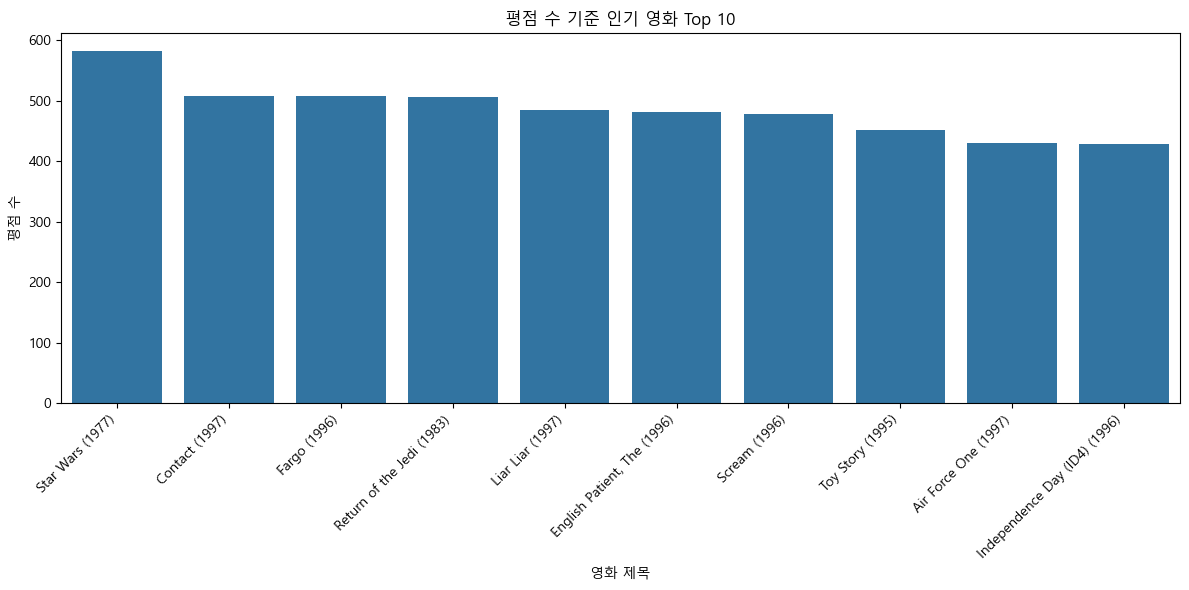

In [17]:
# 인기 영화(평점 수 기준) 상위 10개 시각화
top10_movies = movie_stats.head(10)
plt.figure(figsize=(12,6))
sns.barplot(x='title', y='count', data=top10_movies)
plt.xticks(rotation=45, ha='right')
plt.title('평점 수 기준 인기 영화 Top 10')
plt.xlabel('영화 제목')
plt.ylabel('평점 수')
plt.tight_layout()
plt.show()

# 3. 추천 시스템 구현 (User-Item 협업 필터링 with Surprise 라이브러리)

In [20]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

In [21]:
# Surprise에서 사용할 데이터 준비: (user_id, item_id, rating)
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings_df[['user_id', 'item_id', 'rating']], reader)

In [22]:
# 학습/테스트 데이터 분리
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)


In [23]:
# SVD 모델 학습
algo = SVD(random_state=42)
algo.fit(trainset)

In [24]:
# 테스트셋에 대해 예측 및 평가
predictions = algo.test(testset)
rmse_value = accuracy.rmse(predictions)
print("\n테스트 데이터 RMSE:", rmse_value)

RMSE: 0.9352

테스트 데이터 RMSE: 0.935171451026933


# 4. 간단한 추천 함수: 특정 유저에 대해 아직 평가하지 않은 영화 중 예측 평점이 높은 영화 추천

In [25]:
def get_top_n_recommendations(user_id, n=5):
    """
    user_id: 추천 대상 사용자 ID
    n: 추천할 영화 개수
    """
    # 해당 유저가 이미 평가한 영화 목록
    rated_movies = ratings_df[ratings_df['user_id'] == user_id]['item_id'].unique()
    # 전체 영화 목록
    all_movies = movies_df['item_id'].unique()
    # 평가하지 않은 영화 목록
    unrated_movies = [movie for movie in all_movies if movie not in rated_movies]
    
    # 각 미평가 영화에 대해 예측 평점 산출
    predictions = []
    for movie_id in unrated_movies:
        pred = algo.predict(user_id, movie_id)
        predictions.append((movie_id, pred.est))
        
    # 예측 평점 내림차순 정렬
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # 상위 n개 영화 선택
    top_n_ids = [pred[0] for pred in predictions[:n]]
    top_n_movies = movies_df[movies_df['item_id'].isin(top_n_ids)][['item_id', 'title']]
    return top_n_movies

In [26]:
# 예시: 사용사 ID 1에 대해 Top 5 영화 추천
user_id_example = 1
top_recommendations = get_top_n_recommendations(user_id_example, n=5)
print(f"\n사용자 {user_id_example}에 대한 Top 5 추천 영화:")
print(top_recommendations)


사용자 1에 대한 Top 5 추천 영화:
     item_id                                              title
317      318                            Schindler's List (1993)
356      357             One Flew Over the Cuckoo's Nest (1975)
473      474  Dr. Strangelove or: How I Learned to Stop Worr...
512      513                              Third Man, The (1949)
602      603                                 Rear Window (1954)


# 결과 해석
- **인기 영화 분석:**
    
    영화별 평점 개수를 기준으로 인기 영화(예: *Star Wars (1977)*, *Contact (1997)* 등)를 도출하였으며, 많은 사용자가 평가한 영화들이 리스트 상단에 위치합니다.
    
- **장르별 평점 분석:**
    
    각 장르의 평균 평점을 계산하여, 예를 들어 *Documentary*나 *Drama*와 같이 평점이 높은 장르와 상대적으로 낮은 장르의 경향을 파악할 수 있었습니다.
    
- **모델 평가:**
    
    SVD 기반 추천 모델의 RMSE가 약 0.9352로 나타나, 전체적으로 예측 성능이 괜찮은 수준임을 알 수 있습니다.
    
- **추천 결과:**
    
    사용자 1에게는 기존에 평가하지 않은 영화들 중에서 협업 필터링 모델이 높은 평점을 예측한 영화(예: *Schindler's List (1993)*, *One Flew Over the Cuckoo's Nest (1975)* 등)가 추천되었습니다. 이는 모델이 사용자 취향을 반영해 적절한 추천을 제공할 수 있음을 시사합니다.